<h3>Building a regression model to predict Sales based on various features</h3>

<h5>Author : Saravanan

Date : Feb 2025

© 2025 [Saravanan]. All rights reserved.
Unauthorized use, distribution, or reproduction of this content is prohibited.</h5>

**Importing Libraries**

In [81]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
import joblib
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split,cross_val_score
import optuna
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor


**Loading the Dataset**

In [2]:
# Download the dataset
path = kagglehub.dataset_download("vivek468/superstore-dataset-final")

# Get the first CSV file from the downloaded path
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

# Load the dataset with the correct encoding
if csv_files:
    df = pd.read_csv(os.path.join(path, csv_files[0]), encoding="ISO-8859-1")  # Use 'latin1' if needed
else:
    print("No CSV files found in the dataset.")

**Let's Understand the dataset**

In [3]:
df.shape

(9994, 21)

<h6>The `.shape` attribute shows the expected row count for each column. If the counts don’t match, it indicates missing values in those columns</h6>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

**Key Insights from the Above Code**
1) There are no null values in any column, ensuring data completeness.
2) The dataset contains both numerical (int64, float64) and categorical (object) data types.
3) order_date and ship_date are stored as object data types instead of datetime64, which may affect date-based analysis and performance. Converting them to datetime format will improve efficiency.
4) row_id serves only as an index and does not provide meaningful insights, so it can be removed to optimize the dataset.

In [5]:
obj_cols = df.select_dtypes(include=['object']).columns
obj_cols_lis = [i for i in obj_cols]
#print(obj_cols_lis)
for i in obj_cols_lis:
    print(i," : ",df[i].nunique())

Order ID  :  5009
Order Date  :  1237
Ship Date  :  1334
Ship Mode  :  4
Customer ID  :  793
Customer Name  :  793
Segment  :  3
Country  :  1
City  :  531
State  :  49
Region  :  4
Product ID  :  1862
Category  :  3
Sub-Category  :  17
Product Name  :  1850


In [6]:
df['Country'].value_counts()

Country
United States    9994
Name: count, dtype: int64

<h6>Since the `Country` column contains only a single unique value, it is a constant feature and does not contribute to variability. Therefore, it can be dropped from the dataset</h6>

In [7]:
df.drop('Country',axis=1,inplace=True)

**Converting the columns which has less number of unique values to data type 'category'.**

In [8]:
Threshold = 17

cols_to_change_cat = [i for i in df.select_dtypes(include=['object']).columns if df[i].nunique()<=Threshold]

cols_to_change_cat


['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category']

In [9]:
for i in cols_to_change_cat:
    df[i] = df[i].astype('category') 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Row ID         9994 non-null   int64   
 1   Order ID       9994 non-null   object  
 2   Order Date     9994 non-null   object  
 3   Ship Date      9994 non-null   object  
 4   Ship Mode      9994 non-null   category
 5   Customer ID    9994 non-null   object  
 6   Customer Name  9994 non-null   object  
 7   Segment        9994 non-null   category
 8   City           9994 non-null   object  
 9   State          9994 non-null   object  
 10  Postal Code    9994 non-null   int64   
 11  Region         9994 non-null   category
 12  Product ID     9994 non-null   object  
 13  Category       9994 non-null   category
 14  Sub-Category   9994 non-null   category
 15  Product Name   9994 non-null   object  
 16  Sales          9994 non-null   float64 
 17  Quantity       9994 non-null   in

**Convert `order_date` and `ship_date` to `datetime64` for Better Performance and Analysis**

In [10]:
date_cols = ['Order Date','Ship Date']

for i in date_cols:
    df[i] = pd.to_datetime((df[i]))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   category      
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   category      
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Postal Code    9994 non-null   int64         
 11  Region         9994 non-null   category      
 12  Product ID     9994 non-null   object        
 13  Category       9994 non-null   category      
 14  Sub-Category   9994 non-null   category      
 15  Product Name   9994 n

**Removing `Row ID` from the DataFrame as it is redundant**

In [11]:
df.drop(columns=['Row ID'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Order Date     9994 non-null   datetime64[ns]
 2   Ship Date      9994 non-null   datetime64[ns]
 3   Ship Mode      9994 non-null   category      
 4   Customer ID    9994 non-null   object        
 5   Customer Name  9994 non-null   object        
 6   Segment        9994 non-null   category      
 7   City           9994 non-null   object        
 8   State          9994 non-null   object        
 9   Postal Code    9994 non-null   int64         
 10  Region         9994 non-null   category      
 11  Product ID     9994 non-null   object        
 12  Category       9994 non-null   category      
 13  Sub-Category   9994 non-null   category      
 14  Product Name   9994 non-null   object        
 15  Sales          9994 n

**Let's check duplicates**

In [12]:
int(df.duplicated().sum())

1

In [13]:
df.drop_duplicates(inplace=True)
int(df.duplicated().sum())

0

In [14]:
df.shape

(9993, 19)

**Let's understand the data**

In [15]:
df.describe()

,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,9993,9993,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,2016-04-30 01:53:33.089162240,2016-05-04 00:53:19.039327488,55191.576403,229.852846,3.789753,0.156188,28.660971
min,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.731000
50%,2016-06-26 00:00:00,2016-06-29 00:00:00,56560.000000,54.480000,3.000000,0.200000,8.671000
75%,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,NaN,NaN,32065.074478,623.276074,2.225149,0.206457,234.271476


**Finding Outliers**

<Axes: >

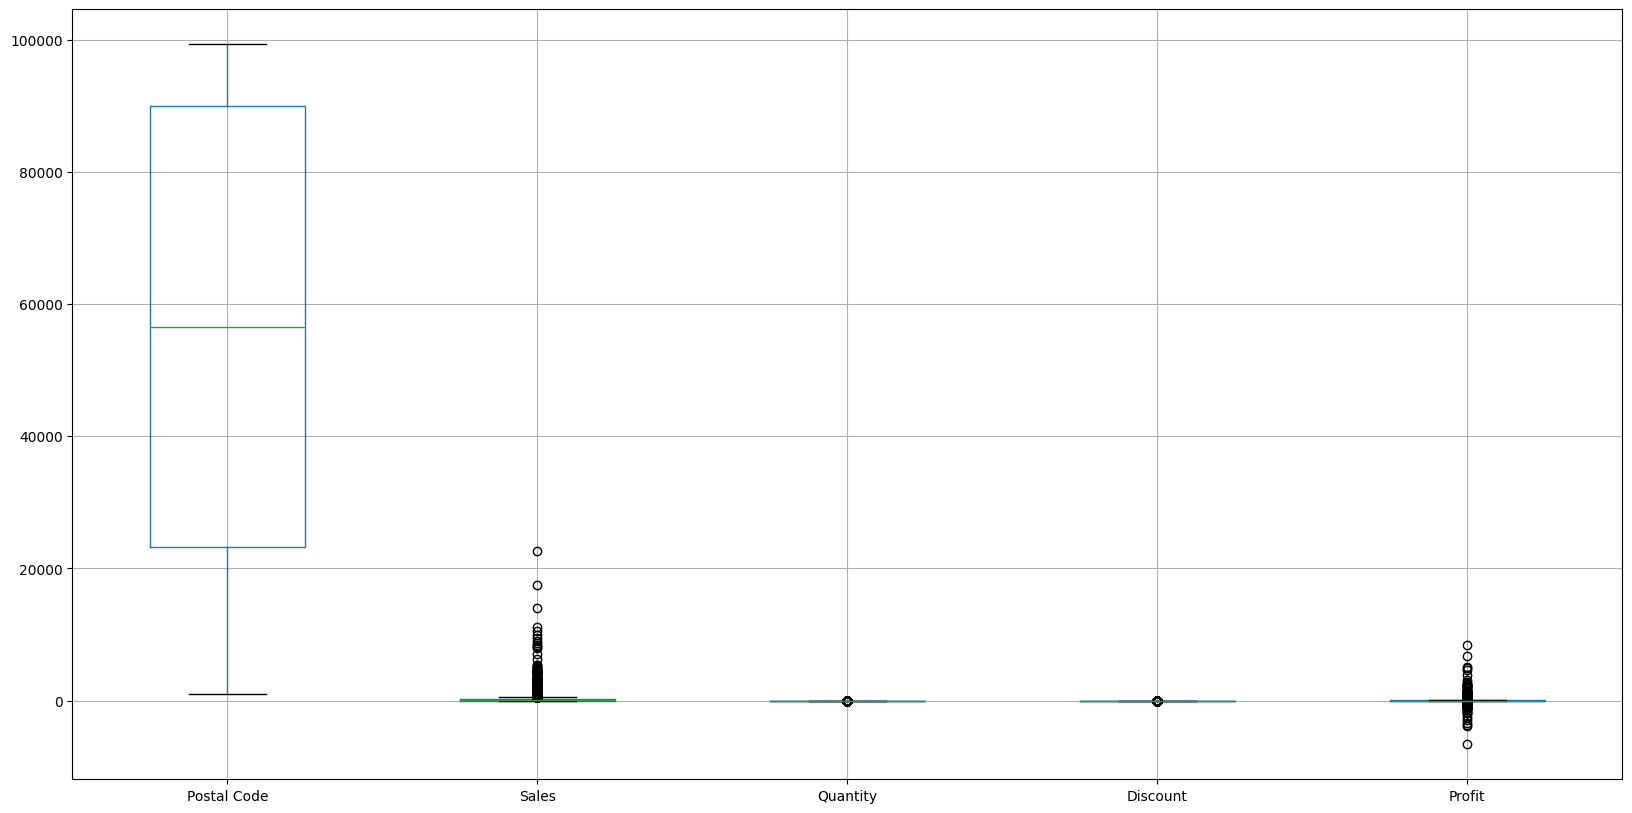

In [16]:
plt.figure(figsize = (20,10))
df.boxplot()

<h5> The boxplot indicates that the 'Sales' feature has outliers on the right extreme, while the 'Profit' feature contains outliers on both ends.</h5> 

<Axes: xlabel='Sales', ylabel='Count'>

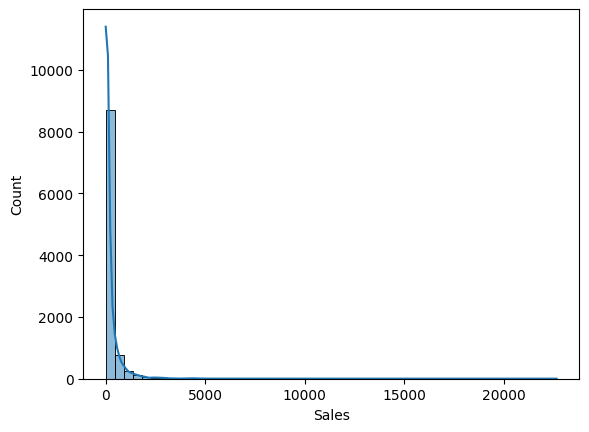

In [17]:
sns.histplot(df['Sales'],bins=50,kde=True)

In [18]:
df['Sales'].describe()

count     9993.000000
mean       229.852846
std        623.276074
min          0.444000
25%         17.280000
50%         54.480000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

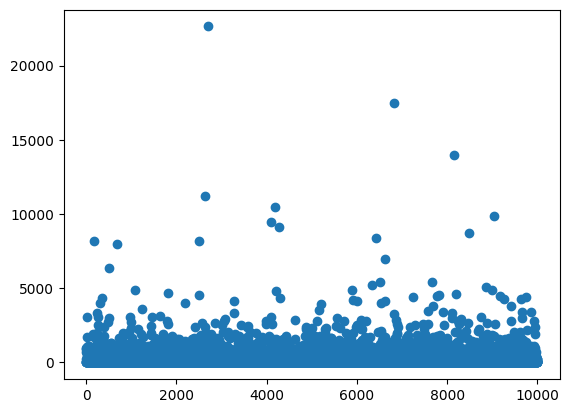

In [19]:
plt.scatter(range(len(df['Sales'])),df['Sales'])

<h5>Few outliers were identified in the Sales feature, which are not seasonality-related, and will be addressed using an imputation method.</h5>

**Handling the outliers**

In [20]:
df['Sales'] = np.log(df['Sales'])

<h5>Log transformation has been applied to treat the outliers, as the Sales data is highly positively skewed.</h5>

<Axes: >

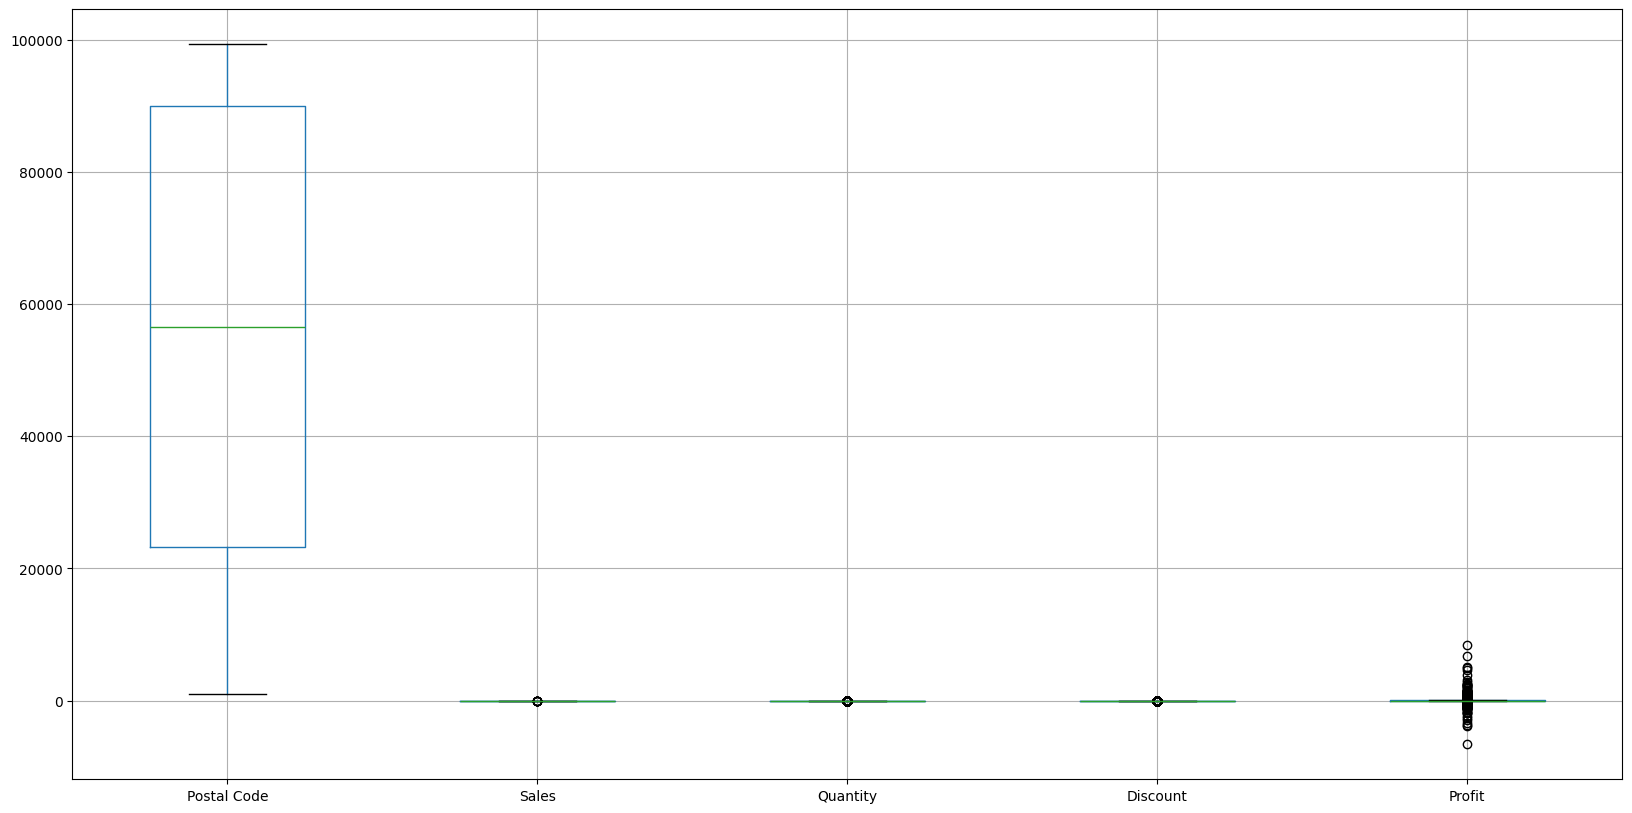

In [21]:
plt.figure(figsize = (20,10))
df.boxplot()

<h5>The chart above clearly shows that the outliers in the Sales data have been transformed, while the profit outliers will remain unaddressed, as Profit is a target feature.</h5>

**Encoding Categorical Data**

In [22]:
cat_cols = [i for i in df.select_dtypes(include=['object','category']).columns]
for i in cat_cols:
    print(i,":",df[i].nunique())

Order ID : 5009
Ship Mode : 4
Customer ID : 793
Customer Name : 793
Segment : 3
City : 531
State : 49
Region : 4
Product ID : 1862
Category : 3
Sub-Category : 17
Product Name : 1850


<h5>Features such as Customer Name, Customer ID, Order ID,Product ID,Product Name have no predictive power and will be removed before applying categorical encoding.</h5>

In [23]:
reductant_cat_cols = ['Customer Name', 'Customer ID', 'Order ID','Product ID','Product Name']

df.drop(reductant_cat_cols,inplace=True, axis=1)

In [24]:
cat_cols = [i for i in df.select_dtypes(include=['object','category']).columns]
for i in cat_cols:
    print(i,":",df[i].nunique())

Ship Mode : 4
Segment : 3
City : 531
State : 49
Region : 4
Category : 3
Sub-Category : 17


In [25]:
less_cardinal_cat_cols = ['Ship Mode','Segment','Region','Category']
med_to_high_cardinal_cat_cols = ['City','State','Sub-Category']

In [26]:
df = pd.get_dummies(df,columns=less_cardinal_cat_cols,drop_first=True,dtype=int)
for i in med_to_high_cardinal_cat_cols:
    target_encoding = df.groupby(i,observed=False)['Profit'].mean().round(2)
    df[i] = df[i].map(target_encoding)
df.head(3)

,Order Date,Ship Date,City,State,Postal Code,Sub-Category,Sales,Quantity,Discount,Profit,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,Region_East,Region_South,Region_West,Category_Office Supplies,Category_Technology
0,2016-11-08,2016-11-11,96.31,80.57,42420,-15.23,5.568192,2,0.0,41.9136,0,1,0,0,0,0,1,0,0,0
1,2016-11-08,2016-11-11,96.31,80.57,42420,43.19,6.595699,3,0.0,219.5820,0,1,0,0,0,0,1,0,0,0
2,2016-06-12,2016-06-16,40.75,38.17,90036,15.24,2.682390,2,0.0,6.8714,0,1,0,1,0,0,0,1,1,0


In [27]:
df['Sub-Category'] = df['Sub-Category'].cat.codes.astype(int)  #This was in categorical datatype even after encoding, so converting that into int

<h5>Categorical columns with low cardinality were converted to numerical values using one-hot encoding, while those with medium to high cardinality were encoded using target encoding, to avoid increasing the dimensionality of the dataset.</h5>

**Let's do Exploratory Data Analysis**

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9993 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Order Date                9993 non-null   datetime64[ns]
 1   Ship Date                 9993 non-null   datetime64[ns]
 2   City                      9993 non-null   float64       
 3   State                     9993 non-null   float64       
 4   Postal Code               9993 non-null   int64         
 5   Sub-Category              9993 non-null   int32         
 6   Sales                     9993 non-null   float64       
 7   Quantity                  9993 non-null   int64         
 8   Discount                  9993 non-null   float64       
 9   Profit                    9993 non-null   float64       
 10  Ship Mode_Same Day        9993 non-null   int32         
 11  Ship Mode_Second Class    9993 non-null   int32         
 12  Ship Mode_Standard Class 

<h5>Since we have time-based date columns, let's extract relevant features to gain new insights and analyze relationships</h5>

In [29]:
df['Order_year'] = df['Order Date'].dt.year
df['Order_month'] = df['Order Date'].dt.month
df['Order_day'] = df['Order Date'].dt.day


df['Ship_year'] = df['Ship Date'].dt.year
df['Ship_month'] = df['Ship Date'].dt.month
df['Ship_day'] = df['Ship Date'].dt.day


df.drop(columns=['Order Date','Ship Date'],axis=1,inplace=True)

<h5>Now we have converted all the datetime features into numerical for our convention</h5>

<h5>Since 'Profit' is the target variable, I'll focus on EDA to analyze how other features impact profit for better dataset understanding</h5>

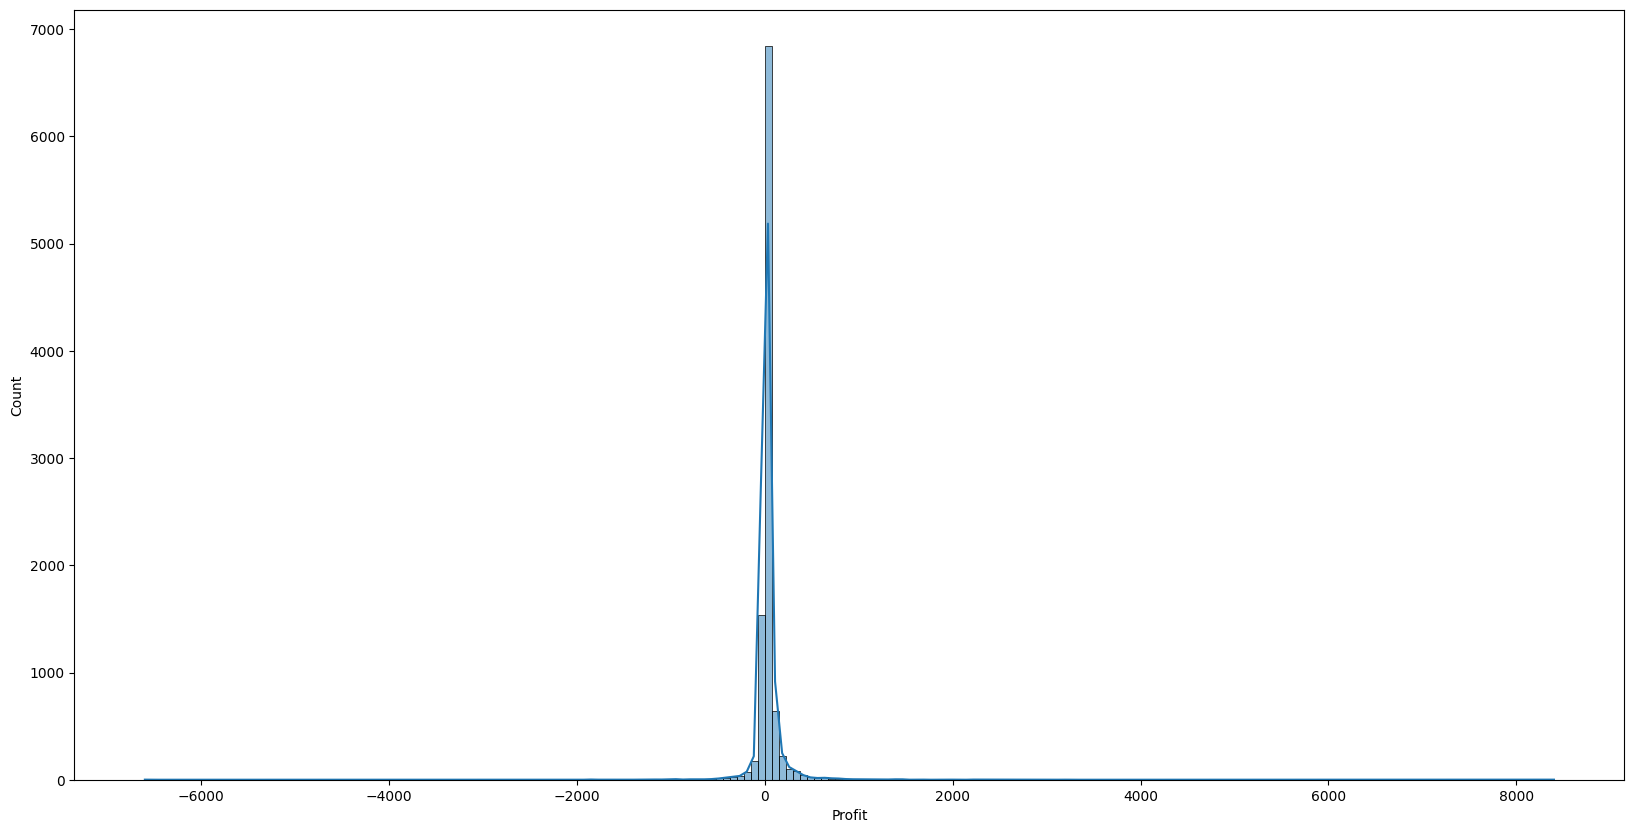

In [30]:
plt.figure(figsize=(20,10))
sns.histplot(df['Profit'],bins=200,kde=True)
plt.show()

In [31]:
profit_skewness = int(df['Profit'].skew())
profit_kurtosis = int(df['Profit'].kurtosis())

profit_shapiro_wilk = stats.shapiro(df['Profit'].sample(500, random_state=42))

print(f"Skewness: {profit_skewness:.4f}")
print(f"Kurtosis: {profit_kurtosis:.4f}")
print(f"Shapiro-Wilk Test Statistic: {profit_shapiro_wilk.statistic:.4f}, p-value: {profit_shapiro_wilk.pvalue:.4f}")

Skewness: 7.0000
Kurtosis: 397.0000
Shapiro-Wilk Test Statistic: 0.4220, p-value: 0.0000


<h5>Since skewness is not close to zero, kurtosis deviates from 3, and the Shapiro-Wilk test shows a p-value lower than the statistic, the target feature 'Profit' does not follow a normal distribution.</h5>

```markdown
 1) Linear models are not suitable since the target variable is not normally distributed, and statistical tests assuming normality cannot be conducted.  
2) Transforming requires reversing values to the original scale for app integration, so tree-based or ensemble models are a better choice.
```

<h5>Now let's analyse some Target-Features relationship</h5>

In [32]:
#Based on domain knowledge I have segregated numerical and categorical columns to analyse the relationship of these features with suitable charts

num_columns = [
    'Sales',
    'Discount'
] 

cat_columns = [
    'Quantity', #Considered quantity as categorical for visual analysis purpose since the values are discrete
    'Postal Code',
    'City',
    'State',
    'Sub-Category',
    'Ship Mode_Same Day',
    'Ship Mode_Second Class',
    'Ship Mode_Standard Class',
    'Segment_Corporate',
    'Segment_Home Office',
    'Region_East',
    'Region_South',
    'Region_West',
    'Category_Office Supplies',
    'Category_Technology',
    'Order_year',
    'Order_month',
    'Order_day',
    'Ship_year',
    'Ship_month',
    'Ship_day'
]

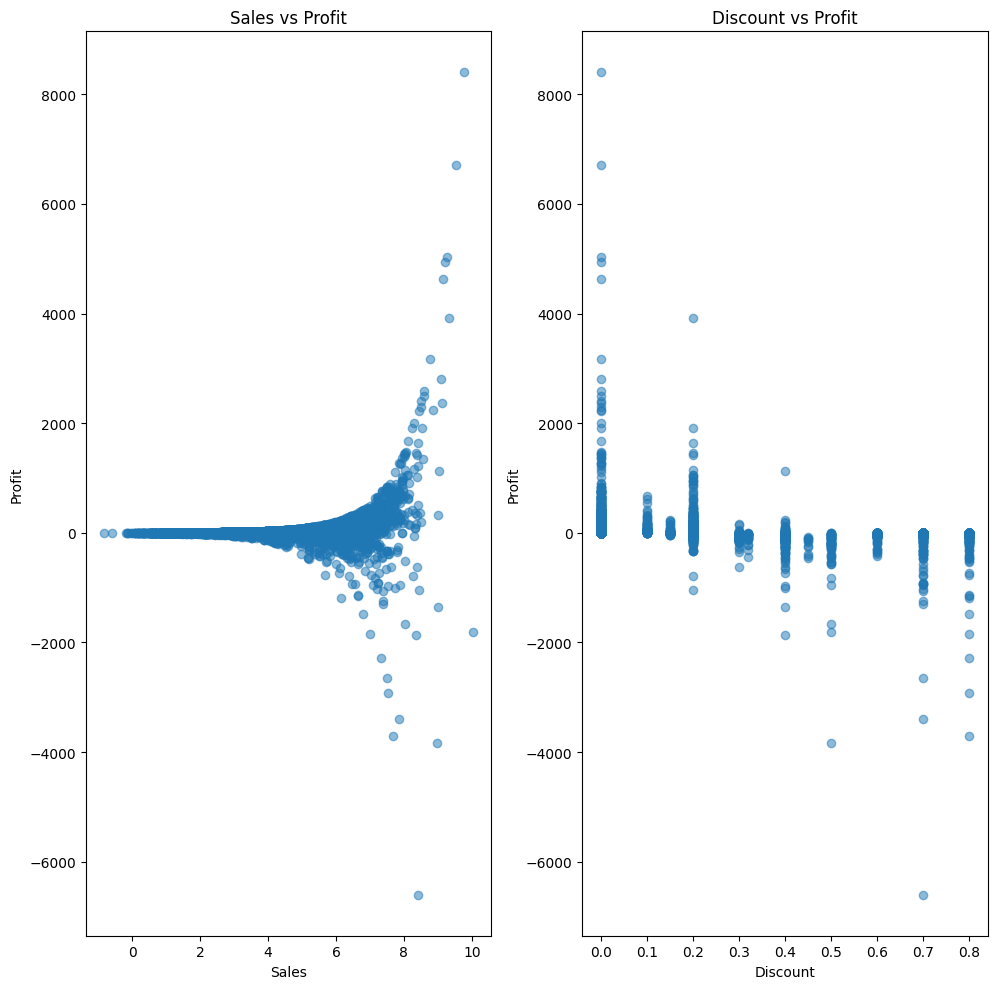

In [33]:
num_plots = len(num_columns)
rows = (num_plots // 4) + (num_plots % 4 > 0)  

plt.figure(figsize=(20,10))
for i, col in enumerate(num_columns, start=1):  
    plt.subplot(rows, 4, i)  
    plt.scatter(df[col], df['Profit'], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Profit")
    plt.title(f"{col} vs Profit")

plt.tight_layout()
plt.show()

```markdown
**Key Insights:**

1) Sales and Profit show a positive relationship, but it is not a straightforward linear one, as we observe some profit drops at higher sales levels. Leveraging linear models is again not suitable for this case.

2) There is a clear negative correlation between Discount and Profit, where an increase in one leads to a decrease in the other, and vice versa.
```

In [34]:
df.columns

Index(['City', 'State', 'Postal Code', 'Sub-Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Ship Mode_Same Day', 'Ship Mode_Second Class',
       'Ship Mode_Standard Class', 'Segment_Corporate', 'Segment_Home Office',
       'Region_East', 'Region_South', 'Region_West',
       'Category_Office Supplies', 'Category_Technology', 'Order_year',
       'Order_month', 'Order_day', 'Ship_year', 'Ship_month', 'Ship_day'],
      dtype='object')

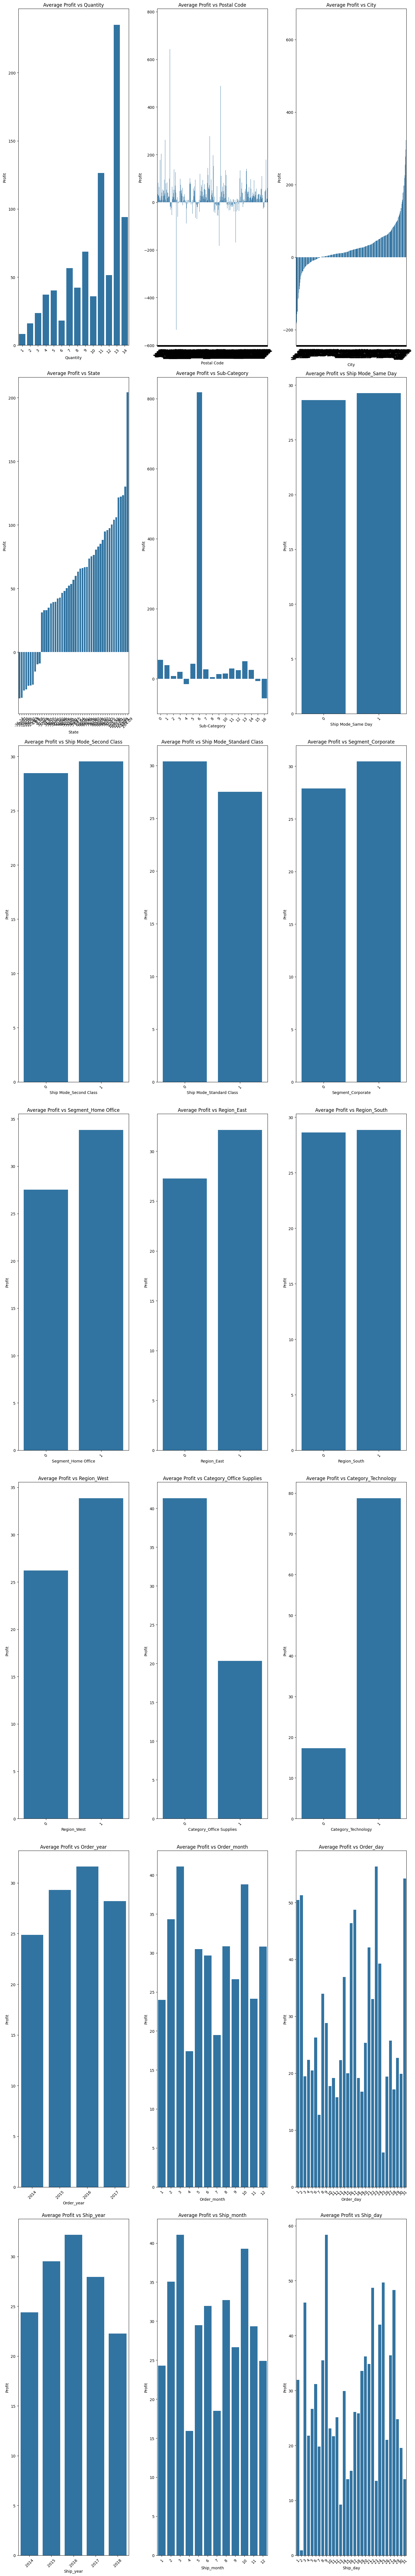

In [35]:
plt.figure(figsize=(15, len(cat_columns) * 5))
for i, feature in enumerate(cat_columns, 1):
    plt.subplot(len(cat_columns) // 3 + 1, 3, i)  
    sns.barplot(x=feature, y='Profit', data=df, errorbar=None)  
    plt.title(f"Average Profit vs {feature}")
    plt.xticks(rotation=45)

plt.tight_layout()  
plt.show()

```markdown
**Key Insights:**

1) Quantity has a positive linear relationship with Profit, but it is not a perfect correlation.  

2) City and State exhibit similar relationships with Profit. Compared to profitable cities and states, cities with losses show less variation, indicating potential multicollinearity.  

3) Postal Code shows significant variability and has little correlation with the target variable. If it does not contribute to feature engineering, we can consider dropping it.  

4) The Sub-Category feature indicates that the 6th sub-category yields the highest profit, while sub-categories 2, 8, and 15 show minimal profit, and sub-categories 4 and 16 result in losses. Instead of keeping all sub-categories, we can group them into four ordinal categories for feature engineering.  

5) Non-office supply categories tend to generate higher profits.  

6) The Technology category shows higher profitability.  

7) Other features exhibit significant variability but do not show clear patterns.  
```

**Let's Do Feature Engineering**

<Axes: xlabel='Sub-Category', ylabel='Profit'>

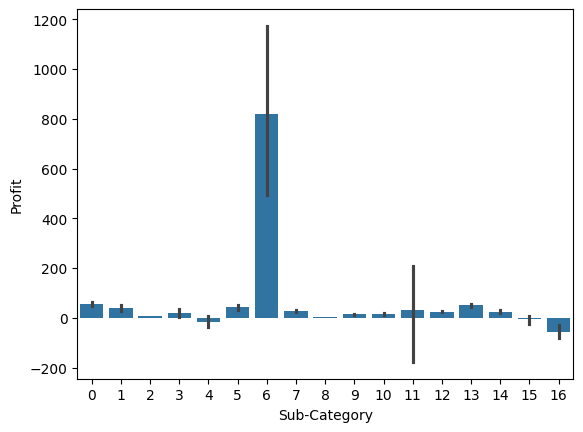

In [36]:
sns.barplot(x='Sub-Category',y='Profit',data=df)

In [37]:
def sub_cat_feat(sub_category):
    if sub_category in [4,16]:
        return 1
    elif sub_category in [2,8,15]:
        return 2
    elif sub_category in [6]:
        return 4
    else:
        return 3
df['sub_cat_feat'] = df['Sub-Category'].apply(sub_cat_feat)
df.drop(columns = ['Sub-Category'],axis=1,inplace=True)
df.head(3)

,City,State,Postal Code,Sales,Quantity,Discount,Profit,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,...,Region_West,Category_Office Supplies,Category_Technology,Order_year,Order_month,Order_day,Ship_year,Ship_month,Ship_day,sub_cat_feat
0,96.31,80.57,42420,5.568192,2,0.0,41.9136,0,1,0,...,0,0,0,2016,11,8,2016,11,11,1
1,96.31,80.57,42420,6.595699,3,0.0,219.5820,0,1,0,...,0,0,0,2016,11,8,2016,11,11,3
2,40.75,38.17,90036,2.682390,2,0.0,6.8714,0,1,0,...,1,1,0,2016,6,12,2016,6,16,3


<h5> Discretized(Binned) Sub-Category based on its relation with the profit feature. </h5>

In [38]:
df['city_state'] = df['City']*df['State']
df.drop(columns=['State','City'],axis=1,inplace=True)
df.head(3)

,Postal Code,Sales,Quantity,Discount,Profit,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Category_Office Supplies,Category_Technology,Order_year,Order_month,Order_day,Ship_year,Ship_month,Ship_day,sub_cat_feat,city_state
0,42420,5.568192,2,0.0,41.9136,0,1,0,0,0,...,0,0,2016,11,8,2016,11,11,1,7759.6967
1,42420,6.595699,3,0.0,219.5820,0,1,0,0,0,...,0,0,2016,11,8,2016,11,11,3,7759.6967
2,90036,2.682390,2,0.0,6.8714,0,1,0,1,0,...,1,0,2016,6,12,2016,6,16,3,1555.4275


<h5>Since City and State are highly collinear, they are combined into a single feature by multiplying them. This will be scaled down later using a transformation.</h5>

In [39]:
df['unit_sales_price'] = (df['Sales']/df['Quantity']).replace(0,1).round(2)
df.head(3)

,Postal Code,Sales,Quantity,Discount,Profit,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Category_Technology,Order_year,Order_month,Order_day,Ship_year,Ship_month,Ship_day,sub_cat_feat,city_state,unit_sales_price
0,42420,5.568192,2,0.0,41.9136,0,1,0,0,0,...,0,2016,11,8,2016,11,11,1,7759.6967,2.78
1,42420,6.595699,3,0.0,219.5820,0,1,0,0,0,...,0,2016,11,8,2016,11,11,3,7759.6967,2.20
2,90036,2.682390,2,0.0,6.8714,0,1,0,1,0,...,0,2016,6,12,2016,6,16,3,1555.4275,1.34


In [40]:
df.columns

Index(['Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Ship Mode_Same Day', 'Ship Mode_Second Class',
       'Ship Mode_Standard Class', 'Segment_Corporate', 'Segment_Home Office',
       'Region_East', 'Region_South', 'Region_West',
       'Category_Office Supplies', 'Category_Technology', 'Order_year',
       'Order_month', 'Order_day', 'Ship_year', 'Ship_month', 'Ship_day',
       'sub_cat_feat', 'city_state', 'unit_sales_price'],
      dtype='object')

In [41]:
df['Discount_flag'] = df['Discount'].apply(lambda x:0 if x==0.00 else 1)

In [42]:
df['Discount'].value_counts()

Discount
0.00    4798
0.20    3657
0.70     418
0.80     300
0.30     226
0.40     206
0.60     138
0.10      94
0.50      66
0.15      52
0.32      27
0.45      11
Name: count, dtype: int64

Since more than 50% of the observations doesn't have discounts, So I am going to bring in a new feature called Discount Flag.

In [43]:
bins = [-1, 0, 0.2, 0.5, 1]  
labels = [0, 1, 2, 3] 
df['Discount_Category'] = pd.cut(df['Discount'], bins=bins, labels=labels)
df['Discount_Category'] = pd.to_numeric(df['Discount_Category'], errors='coerce')


In [44]:
df

,Postal Code,Sales,Quantity,Discount,Profit,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Order_month,Order_day,Ship_year,Ship_month,Ship_day,sub_cat_feat,city_state,unit_sales_price,Discount_flag,Discount_Category
0,42420,5.568192,2,0.00,41.9136,0,1,0,0,0,...,11,8,2016,11,11,1,7759.6967,2.78,0,0
1,42420,6.595699,3,0.00,219.5820,0,1,0,0,0,...,11,8,2016,11,11,3,7759.6967,2.20,0,0
2,90036,2.682390,2,0.00,6.8714,0,1,0,1,0,...,6,12,2016,6,16,3,1555.4275,1.34,0,0
3,33311,6.864407,5,0.45,-383.0310,0,0,1,0,0,...,10,11,2015,10,18,1,95.5488,1.37,1,2
4,33311,3.107631,2,0.20,2.5164,0,0,1,0,0,...,10,11,2015,10,18,3,95.5488,1.55,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,33180,3.228747,3,0.20,4.1028,0,1,0,0,0,...,1,21,2014,1,23,3,179.1984,1.08,1,1
9990,92627,4.521354,2,0.00,15.6332,0,0,1,0,0,...,2,26,2017,3,3,3,1031.3534,2.26,0,0
9991,92627,5.555190,2,0.20,19.3932,0,0,1,0,0,...,2,26,2017,3,3,3,1031.3534,2.78,1,1
9992,92627,3.387774,4,0.00,13.3200,0,0,1,0,0,...,2,26,2017,3,3,3,1031.3534,0.85,0,0


**Let's Do Feature Scaling**

<h5> Let's start by checking the normality for continous numerical features</h5>

In [45]:
numerical_feats = ['Sales','unit_sales_price'] #excluding profit and other categorical encoded features since it is a target variable

In [46]:
df[numerical_feats].astype(int).skew().sort_values().round(2)

Sales               0.20
unit_sales_price    1.58
dtype: float64

<h5>Calculating skewness on discrete feature doesn't makes sense.</h5>

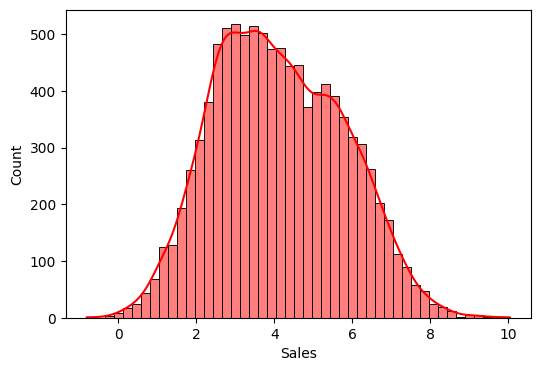

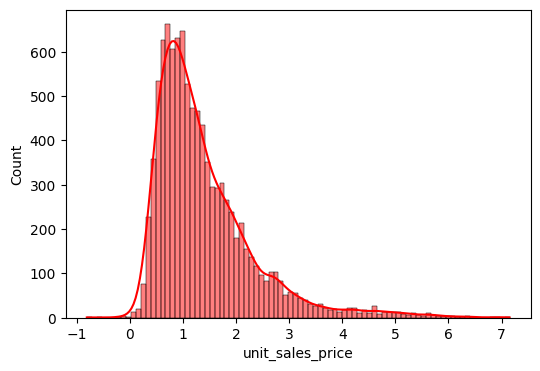

In [47]:
for i in numerical_feats:
    plt.figure(figsize=(6,4))
    sns.histplot(df[i],kde=True,color='red')
    plt.show()

<h5>From the chart, we can see the Sales feature is nearly normally distributed, while the Unit Sales Price feature is right-skewed.</h5>

Before applying scaling to `unit_sales_price`, let's check for outliers to determine the appropriate scaling method.

<Axes: ylabel='unit_sales_price'>

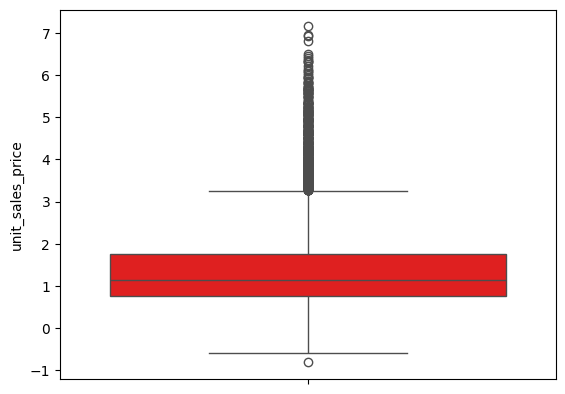

In [48]:
sns.boxplot(df['unit_sales_price'],color='red')

There are significant outliers on the right extreme, so we'll apply a log transformation along with a Quantile Transformer to handle them. Robust Scaler is not considered here since it is better suited for moderate outliers.

In [49]:
df['unit_sales_price'] = np.log1p(df['unit_sales_price'])
Q_transformer = QuantileTransformer()
df['unit_sales_price'] = Q_transformer.fit_transform(df[['unit_sales_price']]) 

<Axes: ylabel='unit_sales_price'>

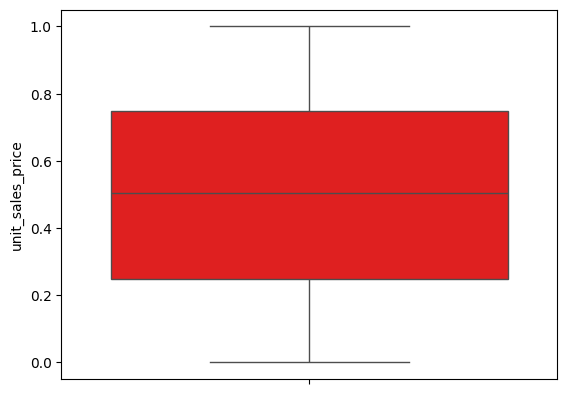

In [50]:
sns.boxplot(df['unit_sales_price'],color='red')

<h5>Let's work on discrete numerical features now</h5>

In general, discrete numerical values don’t require scaling. However, let's check their distribution using frequency analysis.

In [51]:
discrete_numerical_feats = ['Quantity','Discount']

In [52]:
for cols in discrete_numerical_feats:
    print(df[cols].value_counts().sort_values(ascending=False))

Quantity
3     2409
2     2401
5     1230
4     1191
1      899
7      606
6      572
9      258
8      257
10      57
11      34
14      29
13      27
12      23
Name: count, dtype: int64
Discount
0.00    4798
0.20    3657
0.70     418
0.80     300
0.30     226
0.40     206
0.60     138
0.10      94
0.50      66
0.15      52
0.32      27
0.45      11
Name: count, dtype: int64


Since both features have values on a smaller scale, they are left unscaled.

In [53]:
df.describe()

,Postal Code,Sales,Quantity,Discount,Profit,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Order_month,Order_day,Ship_year,Ship_month,Ship_day,sub_cat_feat,city_state,unit_sales_price,Discount_flag,Discount_Category
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,...,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,55191.576403,4.109603,3.789753,0.156188,28.660971,0.054338,0.194636,0.597118,0.302212,0.178325,...,7.810067,15.467727,2015.737616,7.743520,15.882618,2.776944,2546.124395,0.500006,0.519864,0.744821
std,32065.074478,1.643619,2.225149,0.206457,234.271476,0.226695,0.395940,0.490502,0.459239,0.382805,...,3.284598,8.748441,1.126063,3.340433,8.802415,0.544443,4114.763759,0.288714,0.499630,0.900766
min,1040.000000,-0.811931,1.000000,0.000000,-6599.978000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,2014.000000,1.000000,1.000000,1.000000,-29576.722800,0.000000,0.000000,0.000000
25%,23223.000000,2.849550,2.000000,0.000000,1.731000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,8.000000,2015.000000,5.000000,8.000000,3.000000,543.099700,0.247748,0.000000,0.000000
50%,56560.000000,3.997834,3.000000,0.200000,8.671000,0.000000,0.000000,1.000000,0.000000,0.000000,...,9.000000,15.000000,2016.000000,9.000000,16.000000,3.000000,1431.756700,0.503003,1.000000,1.000000
75%,90008.000000,5.346822,5.000000,0.200000,29.364000,0.000000,0.000000,1.000000,1.000000,0.000000,...,11.000000,23.000000,2017.000000,11.000000,24.000000,3.000000,4450.392000,0.748749,1.000000,1.000000
max,99301.000000,10.027406,14.000000,0.800000,8399.976000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,31.000000,2018.000000,12.000000,31.000000,4.000000,47573.181600,1.000000,1.000000,3.000000


<h5>Now, everything is scaled except `city_state`. Let's handle it next.</h5>

In [54]:
df['city_state'].describe()

count     9993.000000
mean      2546.124395
std       4114.763759
min     -29576.722800
25%        543.099700
50%       1431.756700
75%       4450.392000
max      47573.181600
Name: city_state, dtype: float64

The `city_state` feature has no inherent numerical relationship; it represents unique city-state combinations. I'll scale it without treating it as a numerical feature.

In [55]:
df['city_state_encoded'] = df['city_state'].map(df['city_state'].value_counts()) # I have just applied frequency encoding, now it has the unique feature which will be in proper scale.
df.drop(columns = ['city_state'],axis=1,inplace=True)

In [56]:
df.describe()

,Postal Code,Sales,Quantity,Discount,Profit,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Order_month,Order_day,Ship_year,Ship_month,Ship_day,sub_cat_feat,unit_sales_price,Discount_flag,Discount_Category,city_state_encoded
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,...,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,55191.576403,4.109603,3.789753,0.156188,28.660971,0.054338,0.194636,0.597118,0.302212,0.178325,...,7.810067,15.467727,2015.737616,7.743520,15.882618,2.776944,0.500006,0.519864,0.744821,257.454318
std,32065.074478,1.643619,2.225149,0.206457,234.271476,0.226695,0.395940,0.490502,0.459239,0.382805,...,3.284598,8.748441,1.126063,3.340433,8.802415,0.544443,0.288714,0.499630,0.900766,314.352450
min,1040.000000,-0.811931,1.000000,0.000000,-6599.978000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,2014.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,23223.000000,2.849550,2.000000,0.000000,1.731000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,8.000000,2015.000000,5.000000,8.000000,3.000000,0.247748,0.000000,0.000000,15.000000
50%,56560.000000,3.997834,3.000000,0.200000,8.671000,0.000000,0.000000,1.000000,0.000000,0.000000,...,9.000000,15.000000,2016.000000,9.000000,16.000000,3.000000,0.503003,1.000000,1.000000,45.000000
75%,90008.000000,5.346822,5.000000,0.200000,29.364000,0.000000,0.000000,1.000000,1.000000,0.000000,...,11.000000,23.000000,2017.000000,11.000000,24.000000,3.000000,0.748749,1.000000,1.000000,510.000000
max,99301.000000,10.027406,14.000000,0.800000,8399.976000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,31.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,1.000000,3.000000,915.000000


Scaling the target variable is necessary, as its skewed distribution could lead to poor model accuracy. However, we need to reverse the scaling when integrating it with the application.

<Axes: xlabel='Profit', ylabel='Count'>

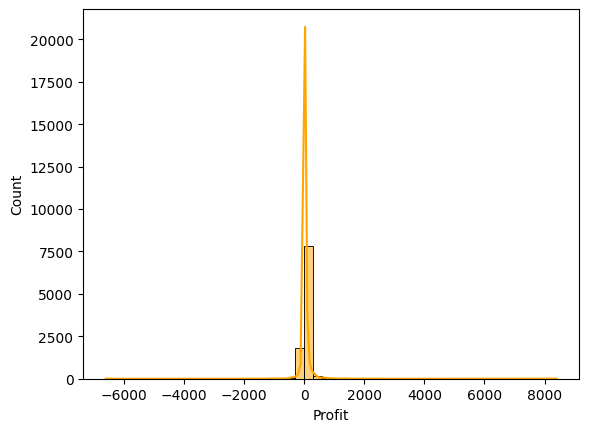

In [57]:
sns.histplot(df['Profit'],kde=True,color='orange',bins=50)

In [58]:
df['Profit'].skew()

7.561035996041442

Based on the chart, the tail extends longer on the right side, and some negative values are present on the left. The skewness is greater than 1 and positive, indicating a heavily right-skewed distribution.Let's use Quantile transformer since it handles the negative values and extreme values and easy to reverse too. 

In [59]:
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df['Profit'] = qt.fit_transform(df[['Profit']])

In [60]:
df['Profit'].skew()

0.0020971856350958003

<Axes: ylabel='Profit'>

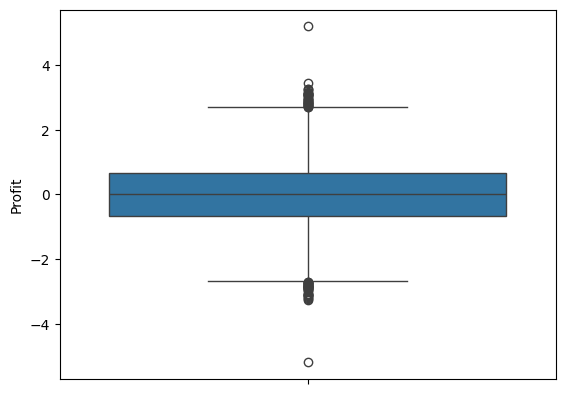

In [61]:
sns.boxplot(df['Profit'])

Not handling the outliers in 'Profit' since it will make the inverse transformation hard and impossible. 

**Let's do Feature Selection**

<h5>Let's Check for Multicollinearity first</h5>

<h5>Let's first compute VIF to assess multicollinearity</h5>

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9993 entries, 0 to 9993
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Postal Code               9993 non-null   int64  
 1   Sales                     9993 non-null   float64
 2   Quantity                  9993 non-null   int64  
 3   Discount                  9993 non-null   float64
 4   Profit                    9993 non-null   float64
 5   Ship Mode_Same Day        9993 non-null   int32  
 6   Ship Mode_Second Class    9993 non-null   int32  
 7   Ship Mode_Standard Class  9993 non-null   int32  
 8   Segment_Corporate         9993 non-null   int32  
 9   Segment_Home Office       9993 non-null   int32  
 10  Region_East               9993 non-null   int32  
 11  Region_South              9993 non-null   int32  
 12  Region_West               9993 non-null   int32  
 13  Category_Office Supplies  9993 non-null   int32  
 14  Category_Tech

Since all features are numerical, including encoded categorical features, we can now calculate VIF for the entire dataset.

In [63]:
def calculate_VIF(df):
    df_numeric = df.select_dtypes(include=['number']).copy()
    df_numeric.insert(0, 'Intercept', 1)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
    

    return vif_data.round(1)
vif_df = calculate_VIF(df)
vif_df

,Feature,VIF
0,Intercept,3239793.5
1,Postal Code,11.3
2,Sales,5.5
3,Quantity,6.7
4,Discount,47.0
5,Profit,2.4
6,Ship Mode_Same Day,1.5
7,Ship Mode_Second Class,2.0
8,Ship Mode_Standard Class,3.9
9,Segment_Corporate,1.1


C:\Users\Dell\AppData\Local\Temp\ipykernel_41620\1346282576.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vif_df["VIF_scaled"], y=vif_df["Feature"], palette="Reds_r")


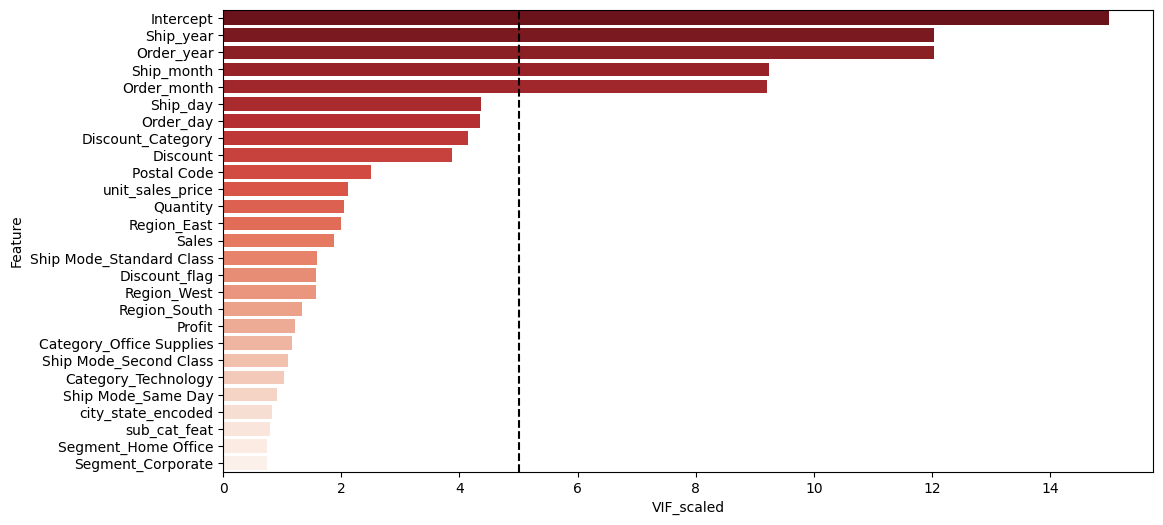

In [64]:
vif_df = vif_df.sort_values(by="VIF", ascending=False)
vif_df["VIF_scaled"] = np.log1p(vif_df["VIF"])  # log(1 + VIF) to avoid log(0)

plt.figure(figsize=(12, 6))
sns.barplot(x=vif_df["VIF_scaled"], y=vif_df["Feature"], palette="Reds_r")

plt.axvline(x=5, color='black', linestyle='--', label="VIF = 5")

In [65]:
vif_threshold = 5
high_vif_feats = vif_df[vif_df["VIF"] > vif_threshold]["Feature"].tolist()
high_vif_feats

['Intercept',
 'Ship_year',
 'Order_year',
 'Ship_month',
 'Order_month',
 'Ship_day',
 'Order_day',
 'Discount_Category',
 'Discount',
 'Postal Code',
 'unit_sales_price',
 'Quantity',
 'Region_East',
 'Sales']

**Computing the correlation to make the strong decision**

<Axes: >

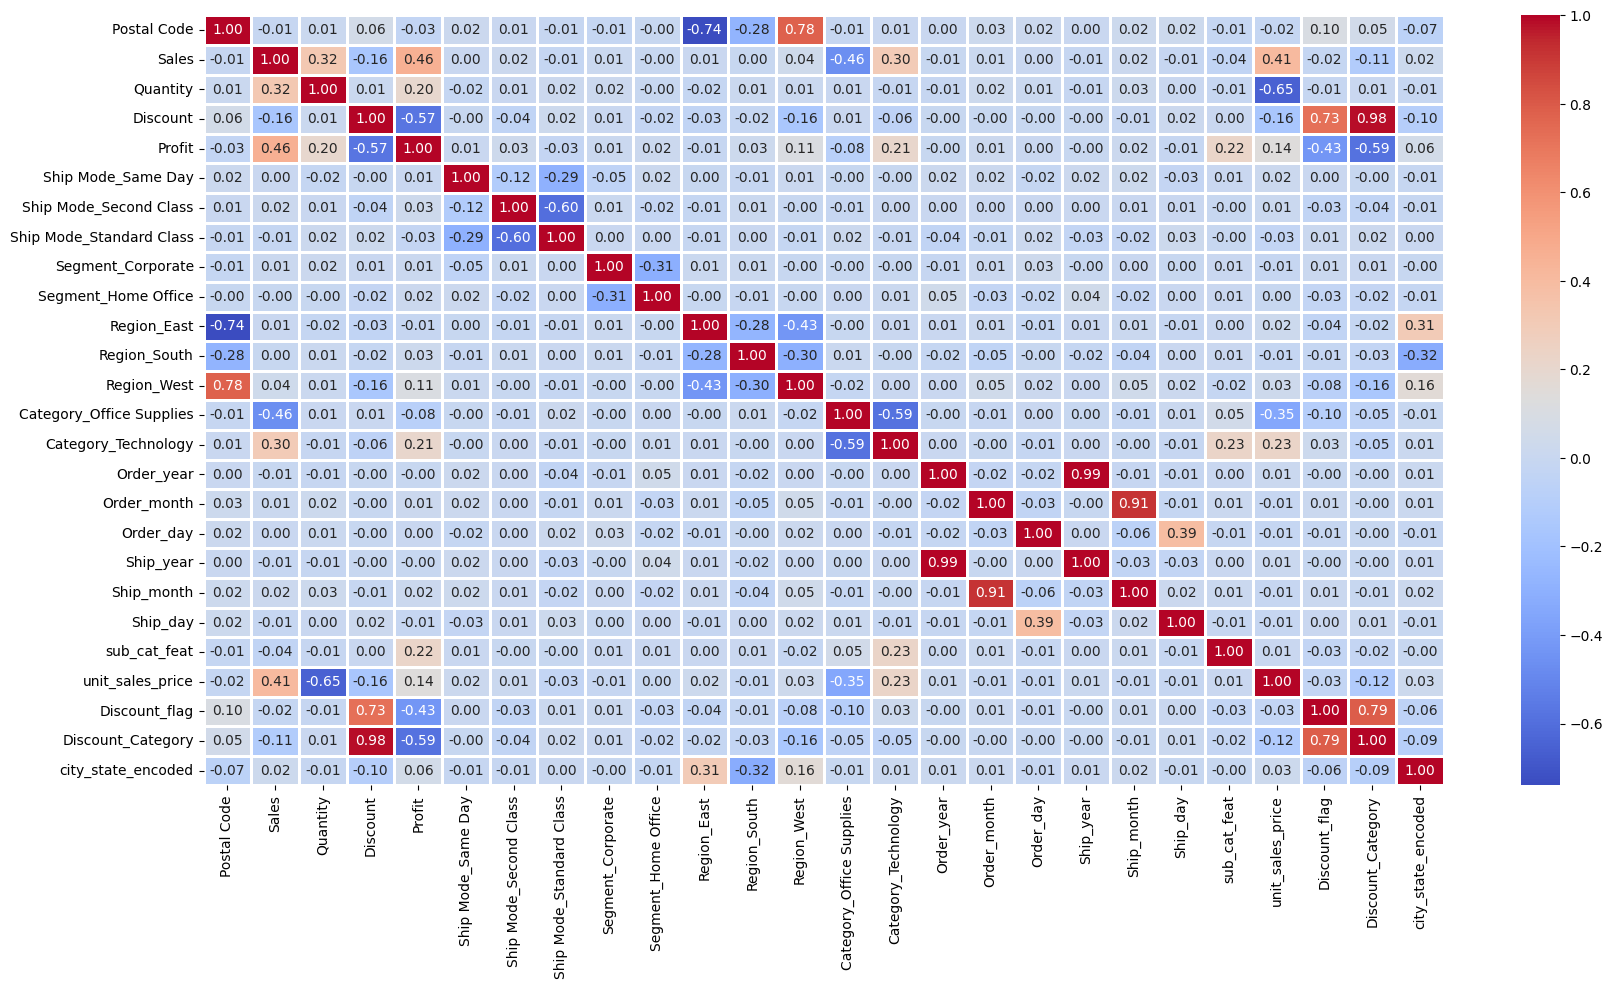

In [66]:
correlation_matrix_df = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix_df,annot=True,cmap="coolwarm",fmt=".2f",linewidths=1)

In [67]:
corr_matrix_threshold = 0.70
high_correlated_feats = set()

for i in range(len(correlation_matrix_df.columns)):
    for j in range(i):
        if abs(correlation_matrix_df.iloc[i, j]) > corr_matrix_threshold:
            col1 = correlation_matrix_df.columns[i]
            col2 = correlation_matrix_df.columns[j]
            high_correlated_feats.add((col1, col2))  # Store as a tuple

high_correlated_feats = list(high_correlated_feats)  # Convert to list if needed
high_correlated_feats

[('Ship_month', 'Order_month'),
 ('Ship_year', 'Order_year'),
 ('Region_West', 'Postal Code'),
 ('Discount_flag', 'Discount'),
 ('Region_East', 'Postal Code'),
 ('Discount_Category', 'Discount_flag'),
 ('Discount_Category', 'Discount')]

**Now, we will compare high VIF features and highly multicollinear features and remove the common ones**

In [68]:
high_vif_feats

['Intercept',
 'Ship_year',
 'Order_year',
 'Ship_month',
 'Order_month',
 'Ship_day',
 'Order_day',
 'Discount_Category',
 'Discount',
 'Postal Code',
 'unit_sales_price',
 'Quantity',
 'Region_East',
 'Sales']

By comparing VIF and the correlation matrix, I have identified the columns to remove to eliminate multicollinearity.

In [69]:
feats_to_remove = ['Postal Code','Order_month','Ship_year','Discount_Category'] #Not including Discount flag or Discount related other Discount even though there are some multicollinearity considering upcoming wrapper feature selection method
df.drop(feats_to_remove,axis=1,inplace=True)

**Let's check if we have fixed multicollinearity with correlation matrix and VIF calculation**

C:\Users\Dell\AppData\Local\Temp\ipykernel_41620\2297582189.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vif_df["VIF_scaled"], y=vif_df["Feature"], palette="Reds_r")


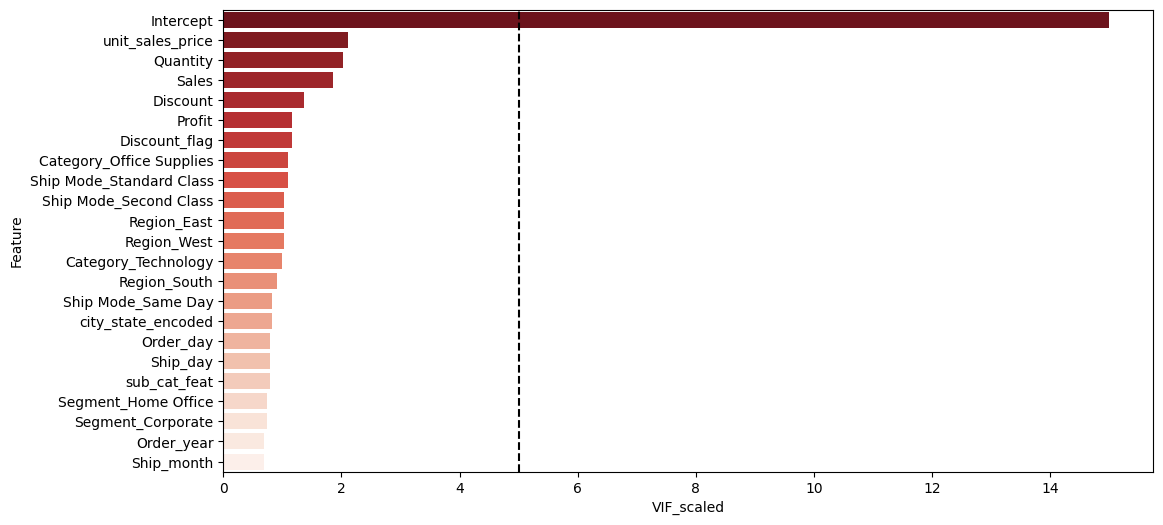

In [70]:
def calculate_VIF(df):
    df_numeric = df.select_dtypes(include=['number']).copy()
    df_numeric.insert(0, 'Intercept', 1)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

    return vif_data.round(1)
vif_df = calculate_VIF(df)

vif_df = vif_df.sort_values(by="VIF", ascending=False)
vif_df["VIF_scaled"] = np.log1p(vif_df["VIF"])  # log(1 + VIF) to avoid log(0)

plt.figure(figsize=(12, 6))
sns.barplot(x=vif_df["VIF_scaled"], y=vif_df["Feature"], palette="Reds_r")

plt.axvline(x=5, color='black', linestyle='--', label="VIF = 5")

<Axes: >

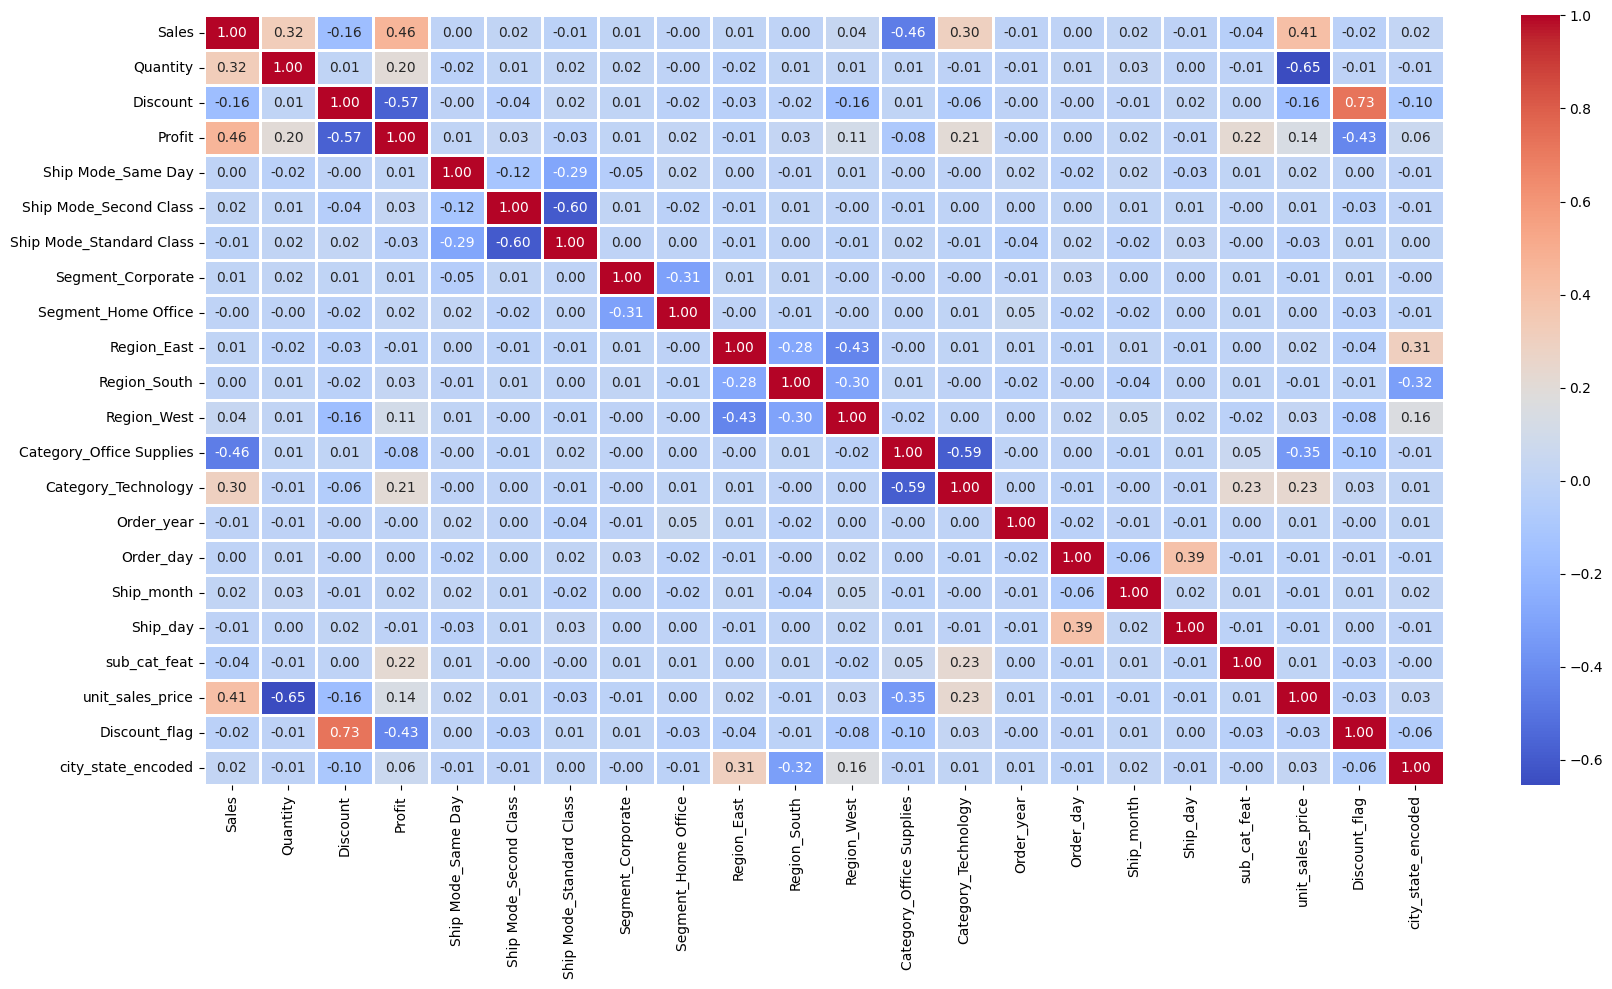

In [71]:
correlation_matrix_df = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix_df,annot=True,cmap="coolwarm",fmt=".2f",linewidths=1)

<h5>We have resolved the multicollinearity issue by removing highly correlated features, bringing VIF and correlation matrix scores under control.</h5>

To understand the relationship of all independent features with the target variable from multiple perspectives, I will combine Mutual Information (MI), Feature Importance, and Spearman Correlation, assigning appropriate weightage to each.

In [72]:
y = df['Profit']
X = df.drop('Profit',axis=1)

# Compute Correlation (Spearman for better non-linear capture)
correlation_values = df.corr(method='spearman')['Profit'].drop('Profit').abs()

# Compute Mutual Information
mi_values = mutual_info_regression(X, y, random_state=42)
mi_values /= mi_values.max()  # Normalize between 0 and 1

# Compute Feature Importance using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
fi_values = rf.feature_importances_

# Normalize Feature Importance to range [0, 1]
fi_values /= fi_values.max()

# Create DataFrame
df_scores = pd.DataFrame({
    'Feature': X.columns,
    'Correlation': correlation_values.values,  # Convert Series to array
    'Mutual_Information': mi_values,
    'Feature_Importance': fi_values
})

# Combine the scores with weights (for example, equal weight)
weights = {
    'Correlation': 0.33,
    'Mutual_Information': 0.33,
    'Feature_Importance': 0.34
}

# Calculate combined score
df_scores['Combined_Score'] = (df_scores['Correlation'] * weights['Correlation'] +
                               df_scores['Mutual_Information'] * weights['Mutual_Information'] +
                               df_scores['Feature_Importance'] * weights['Feature_Importance'])

# Sort by Combined Score
df_scores = df_scores.set_index('Feature').sort_values(by='Combined_Score', ascending=False)

# Display
print(df_scores)

                          Correlation  Mutual_Information  Feature_Importance  \
Feature                                                                         
Sales                        0.518682            1.000000            0.982344   
Discount                     0.543221            0.233996            1.000000   
unit_sales_price             0.159628            0.425330            0.108680   
Discount_flag                0.430213            0.122154            0.013851   
Quantity                     0.234409            0.161013            0.018153   
sub_cat_feat                 0.220304            0.091359            0.066083   
Category_Technology          0.210261            0.053577            0.035665   
Category_Office Supplies     0.107470            0.076989            0.022765   
Region_West                  0.114313            0.015767            0.009003   
city_state_encoded           0.007723            0.034338            0.052085   
Ship_day                    

Considering lower overall score, dropping these below features 

In [73]:
cols_to_drop = ["Region_East",
    "Segment_Corporate",
    "Order_year",
    "Segment_Home Office",
    "Region_South",
    "Ship Mode_Standard Class",
    "Ship Mode_Second Class",
    "Ship Mode_Same Day"]

df.drop(columns=cols_to_drop,inplace=True,axis=1)

Since we have fewer than 30 features, the wrapper method is suitable for feature selection. We'll use a Random Forest model to identify the best features, as linear models are not ideal based on our EDA insights.

<Axes: >

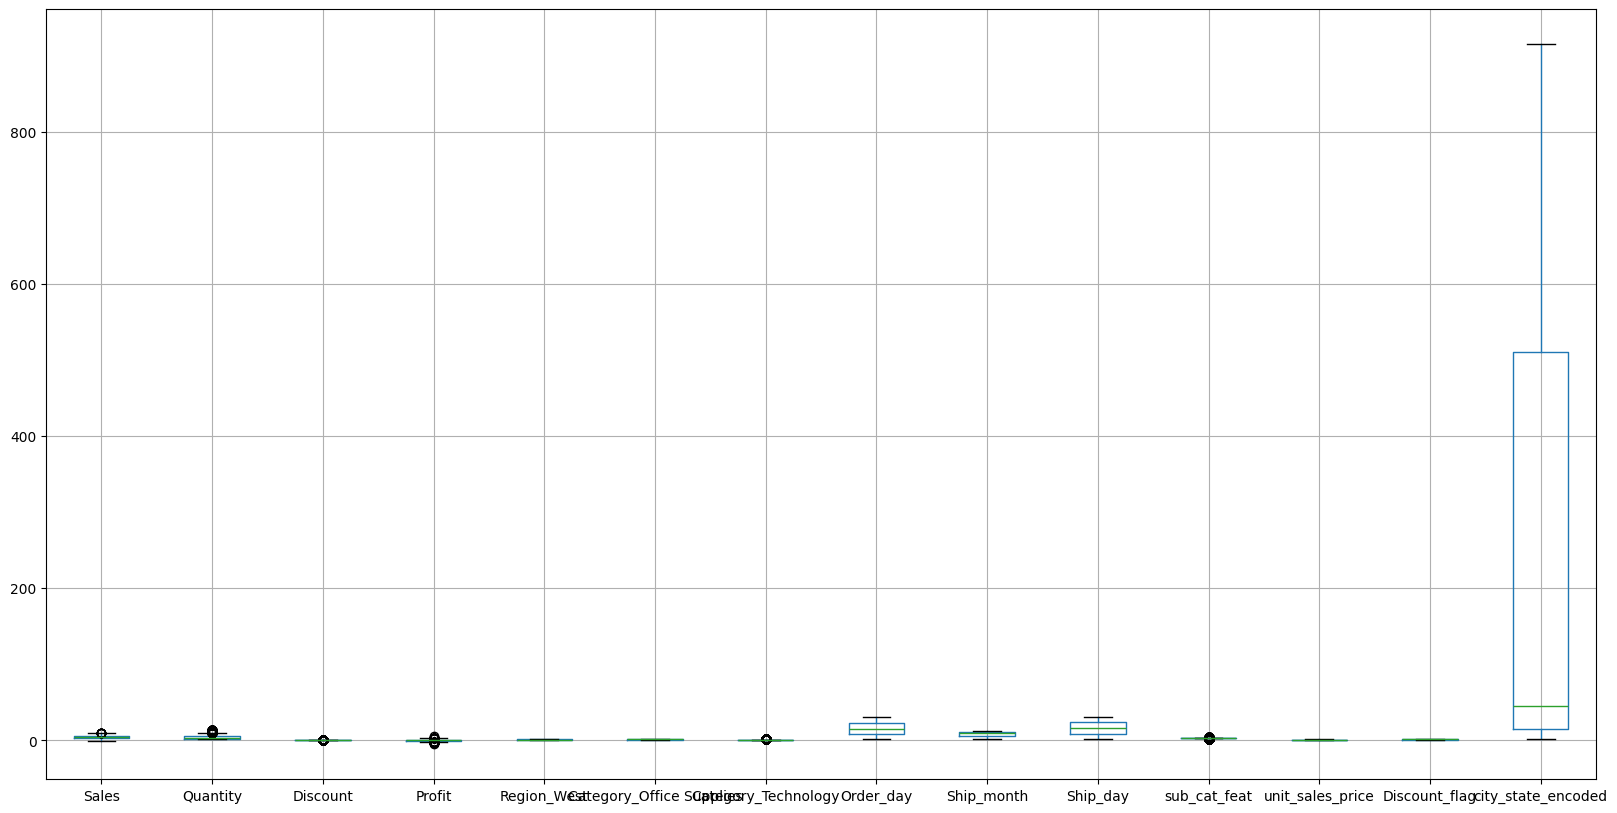

In [74]:
plt.figure(figsize = (20,10))
df.boxplot()

**Now let's do the feature selection using random forest model and do the splitting for testing and training purpose**

In [75]:
X =df.drop(columns=['Profit'])
y =df['Profit']

In [76]:
rf_fs = RandomForestRegressor(n_estimators=100, max_depth=26, random_state=42)
rf_fs.fit(X, y)

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_fs.feature_importances_})
selected_features = feature_importance.sort_values(by='Importance', ascending=False)['Feature'][:11].values

X_selected = X[selected_features]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

After multiple trial-and-error experiments, 11 features provided the best accuracy.

**Using Optuna technique for hyperparameter tuning and selecting XGBoost as the final model**

In [ ]:
#  Define Optuna Optimization Function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    model = xgb.XGBRegressor(**params, random_state=42)

    #  Train model without early stopping rounds
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)], 
        verbose=False
    )

    preds = model.predict(X_valid)
    return r2_score(y_valid, preds)  # Optuna maximizes this

#  Run Optuna Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#  Best Parameters from Optuna
best_params = study.best_params
print("Best Hyperparameters:", best_params)

#  Train Final Model with Best Parameters
final_model = xgb.XGBRegressor(**best_params, random_state=42)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)], 
    verbose=False
)

# Evaluate on Test Set
y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Final Model R²:", r2)

[I 2025-02-22 20:37:18,124] A new study created in memory with name: no-name-b7c0c216-77d2-4565-959a-53deb8ba5cc2
[I 2025-02-22 20:37:20,140] Trial 0 finished with value: 0.7739542855697876 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.22779498098303783, 'subsample': 0.9126580106803159, 'colsample_bytree': 0.6464173761896708, 'reg_alpha': 0.17192094426678461, 'reg_lambda': 8.29340962896216}. Best is trial 0 with value: 0.7739542855697876.
[I 2025-02-22 20:37:20,461] Trial 1 finished with value: 0.7803826861070278 and parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.14724198507471026, 'subsample': 0.820081724420245, 'colsample_bytree': 0.5233323995175705, 'reg_alpha': 0.2708289384137541, 'reg_lambda': 0.10142832946972935}. Best is trial 1 with value: 0.7803826861070278.
[I 2025-02-22 20:37:21,011] Trial 2 finished with value: 0.7831376040665201 and parameters: {'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.07655608526313257, 'su

Best Hyperparameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.02389888360394049, 'subsample': 0.651059773088497, 'colsample_bytree': 0.8040060768165123, 'reg_alpha': 0.5462477994257068, 'reg_lambda': 2.5984227518220644}
Final Model R²: 0.7825809170260123


Best set of parameters : 'n_estimators': 1000, 'max_depth': 14, 'learning_rate': 0.025039488993668285, 'subsample': 0.9606561580921507, 'colsample_bytree': 0.8270405844688365, 'reg_alpha': 6.750989015930306, 'reg_lambda': 3.1477752282026006

In [78]:
# ✅ Train Final Model with Best Parameters
final_model = XGBRegressor(
    n_estimators=1000,
    max_depth=14,
    learning_rate=0.025039488993668285,
    subsample=0.9606561580921507,
    colsample_bytree=0.8270405844688365,
    reg_alpha=6.750989015930306,
    reg_lambda=3.1477752282026006,
    random_state=42
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)], 
    verbose=False
)

# ✅ Evaluate on Test Set
y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Final Model R²:", r2)

Final Model R²: 0.7756081780839453


Even after applying various feature engineering techniques, optimizations, hyperparameter tuning, and testing different models (including stacking), this was the best achieved accuracy.

**Let's pickle this model to save and load it with the app**

In [79]:
import pickle


model_path = r"C:\Users\Dell\OneDrive\Desktop\All Project Details\Retail_Sales_Data_Project_Files\online_sales_model.pkl"

with open(model_path, "wb") as file:
    pickle.dump(final_model, file)  

print(f"Model saved at: {model_path}")

Model saved at: C:\Users\Dell\OneDrive\Desktop\All Project Details\Retail_Sales_Data_Project_Files\online_sales_model.pkl
